<h1><center> Assignment 1: EDA United Nations General Debate Corpus  </center></h1>

Import the files containing speeches from year 1970 until 2020 and turn it into a data frame.

In [4]:
import os
import numpy as np
import pandas as pd
import re

# Code provided by lab 3
sessions = np.arange(25, 76)
data=[]

for session in sessions:
    directory = "./TXT/Session "+str(session)+" - "+str(1945+session)
    for filename in os.listdir(directory):
        f = open(os.path.join(directory, filename), encoding = 'utf8')
        if filename[0]==".": #ignore hidden files
            continue
        splt = filename.split("_")
        data.append([session, 1945+session, splt[0], f.read()])

        
df_speech = pd.DataFrame(data, columns=['Session','Year','ISO-alpha3 Code','Speech'])

In [5]:
# Country names and code dataset
iso = pd.read_csv('country_ISO.csv')

Import file containing general information about counties taking part in the UNSD.

In [6]:
df_codes = pd.read_csv('UNSD — Methodology.csv') # Something to think about is if this data is optimal as it does 
                                                 # not contain a year or any sort of changes, it is just the most 
                                                 # recent status which might not have been the same as in 1970, 
                                                 # see: https://unstats.un.org/unsd/methodology/m49/#changes

Combine the speech data frame and the general information data frame.

In [7]:
df = df_speech.merge(df_codes, on="ISO-alpha3 Code", how="left") # A left join is used as we want the
                                                                 # data to be joined for every row
df.set_index(["Year"], inplace = True)                           # Creates indexed data frame

The Natural Language Toolkit (NLTK) will be used for pre-processing and text analysis.

In [1]:
import nltk

nltk.download("wordnet")
nltk.download("stopwords")
nltk.download('punkt')

from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag

stop_words = set(stopwords.words("english"))

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/dimitrihooftman/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dimitrihooftman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/dimitrihooftman/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Create some reusable functions.

In [223]:
def clean_string(text):                                          # Resource used: https://monkeylearn.com/blog/text-cleaning/
    text = text.lower()                                          # Set all text to lower string
    text = re.sub(r"http.*?(?=\s)", "", text)                    # Remove URL's
    text = re.sub(r"[^A-z\s]", "", text)                         # Remove punctuation and numbers
    text = re.sub(" +", " ", text)                               # Remove multiple spaces
    text = re.sub("united nations", "UN",text)
    text = re.sub("united states", "unitedstates",text)
    
    word_tokens = nltk.word_tokenize(text)
          
    filtered_text = [] 

    for token in word_tokens:                                    # Remove stop words
        if token not in stop_words:
            filtered_text.append(token) 
    
    lemmatized_text = []
    
    for word in filtered_text:                                   # Group words having the same meaning
         lemmatized_text.append(lemmatizer.lemmatize(word))

    return " ".join(lemmatized_text)

Q4.1: Are terrorism related words used more often after a terrorist attack taking place?

In [309]:
from nltk.probability import FreqDist

df_q4_1 = df

terrorism_count = pd.DataFrame()

for year, data in df_q4_1.iterrows():
    terrorism_related_words = {                                                        # From https://relatedwords.org/relatedto/terrorism, this list could be larger
        "terrorism" : 0,
        "terrorization" : 0,
        "violence" : 0,
        "terror" : 0,
        "qaeda" : 0,
        "fear" : 0,
        "ideology" : 0,
        "reign" : 0,
        "insurgent" : 0,
    }

    cleaned_speech = clean_string(data[["Speech"]][0])

    for word in nltk.word_tokenize(cleaned_speech):
        if word in terrorism_related_words:                      
            terrorism_related_words[word] += 1
    
    terrorism_related_words["year"] = year

    terrorism_count = terrorism_count.append(terrorism_related_words, ignore_index=True)

terrorism_count.insert(0, "year", terrorism_count.pop("year"))

terrorism_count.to_csv('./terrorism_count.csv', sep=',', index = None, encoding='utf-8', header='true')

Text(0.5, 1.0, 'Usage of terrorism related words')

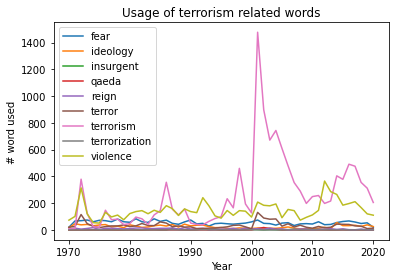

In [380]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

terrorism_count = pd.read_csv('terrorism_count.csv')

terrorism_count = terrorism_count.groupby("year").sum()
plt.plot(terrorism_count)

plt.legend(terrorism_count.columns)
plt.xlabel("Year")
plt.ylabel("# word used")
plt.title("Usage of terrorism related words")

Q4.2: By whom and how much is a country referred to by other countries in the year after a terrorist attack?

In [228]:
def save_referrences_by_countries():
    df_q4_2 = df

    country_names_q4_2 = df_q4_2.reset_index()[["Country or Area", "ISO-alpha3 Code"]].drop_duplicates().dropna()       # Get a list of full names with their ISO code
    country_names_q4_2["Country or Area"] = country_names_q4_2["Country or Area"].apply(lambda name: name.lower())

    country_names_q4_2["Country or Area"].replace({"united states of america": "unitedstates"}, inplace=True)           # This will probably have to be done for more country's

    country_names_dict_q4_2 = dict(country_names_q4_2.values)

    referrer_count = pd.DataFrame()

    for i, row in df_q4_2.iterrows():                                                                                   # Go through all speeches
        referrer_count_year = dict()

        referrer_count_year["Year"] = i
        referrer_count_year["ISO-alpha3 Code"] = row["ISO-alpha3 Code"]

        speech = clean_string(row["Speech"])                                                                            # Clean speech text

        speech_tokens = nltk.word_tokenize(speech)                                                                      # Split text into words for individual analysis

        for word in speech_tokens:                                                                                      # Go through individual words in speech
            
            if word in country_names_dict_q4_2:
                country_name = word
                country_code = country_names_dict_q4_2[word]

                if country_code != row["ISO-alpha3 Code"] and country_name.lower() in word:                             # If country mentioned another country, add to counter in dictionary
                    if country_code in referrer_count_year:
                        referrer_count_year[country_code] += 1
                    else:
                        referrer_count_year[country_code] = 1

        referrer_count = referrer_count.append(referrer_count_year, ignore_index=True)

    referrer_count.insert(0, "ISO-alpha3 Code", referrer_count.pop("ISO-alpha3 Code"))
    referrer_count.insert(1, "Year", referrer_count.pop("Year"))
    referrer_count = referrer_count.fillna(0)

    referrer_count.to_csv('./referrences.csv', sep=',', index = None, encoding='utf-8', header='true')

# save_referrences_by_countries()

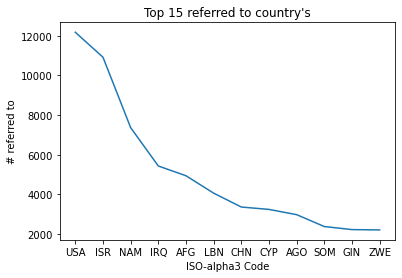

In [240]:
referrences = pd.read_csv('referrences.csv')

per_year = referrences.sum().drop(labels=["ISO-alpha3 Code", "Year"]).sort_values(ascending=False)

plt.plot(per_year.iloc[:12])

plt.xlabel("ISO-alpha3 Code")
plt.ylabel("# referred to")
plt.title("Top 12 referred to country's")

plt.show()

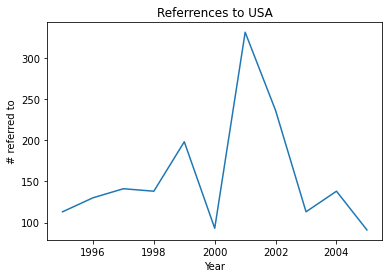

In [269]:
use_referred_per_year = referrences.groupby("Year").sum()[["USA"]].loc[1995.0:2005.0]

plt.plot(use_referred_per_year)

plt.xlabel("Year")
plt.ylabel("# referred to")
plt.title("Referrences to USA")

plt.show()                                                                                 # We see a spike after the US Embassy Bombings and September 11 attacks of country's referring to the USA

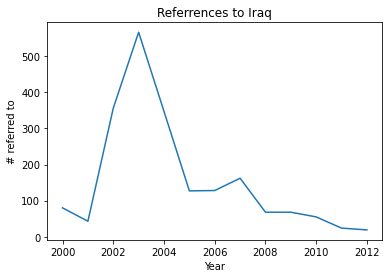

In [271]:
use_referred_per_year = referrences.groupby("Year").sum()[["IRQ"]].loc[2000.0:2012.0]

plt.plot(use_referred_per_year)

plt.xlabel("Year")
plt.ylabel("# referred to")
plt.title("Referrences to Iraq")

plt.show()         

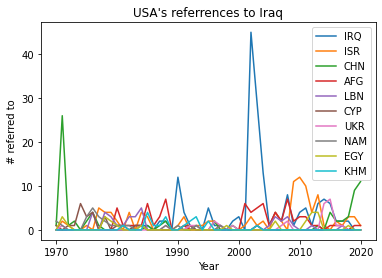

In [379]:
usa_referrences = referrences[referrences["ISO-alpha3 Code"] == "USA"]
usa_referrences = usa_referrences.drop("ISO-alpha3 Code", axis = 1)
usa_referrences = usa_referrences.set_index("Year")

top_10_mentioned = usa_referrences.sum().nlargest(10).index

usa_referrences = usa_referrences[['IRQ', 'ISR', 'CHN', 'AFG', 'LBN', 'CYP', 'UKR', 'NAM', 'EGY', 'KHM']]

plt.plot(usa_referrences)

plt.legend(usa_referrences)
plt.xlabel("Year")
plt.ylabel("# referred to")
plt.title("USA's referrences to Iraq")

plt.show()       

In [53]:
# Have countries always participated? # visualization of what countries participated to UN speeches through time
# df['ISO-alpha2 Code'].value_counts().plot(kind='hist')
# df['ISO-alpha2 Code'].value_counts() #194 countries, 193 members so probably east germany?
df.groupby(by='Year')['ISO-alpha2 Code'].value_counts()

Year  ISO-alpha2 Code
1970  AL                 1
      AR                 1
      AT                 1
      AU                 1
      BE                 1
                        ..
2020  WS                 1
      YE                 1
      ZA                 1
      ZM                 1
      ZW                 1
Name: ISO-alpha2 Code, Length: 8353, dtype: int64

## Adam Ideas for alternative datasets:

military expenditure:
https://data.worldbank.org/indicator/MS.MIL.XPND.GD.ZS

Please note, the below dataset still needs to be cleaned further

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df_mil = pd.read_excel("Military_exp.xlsx")
df_mil.info()
df_mil

XLRDError: Excel xlsx file; not supported

### Which years had the highest defense budget?

In [ ]:
# df_mil_years = df_mil.groupby('Country Name').aggregate(max)
# df_mil_years

df_mil_years = df_mil.max(skipna=True)
print(df_mil_years)


Country Name                             Zimbabwe
Country Code                                  ZWE
Indicator Name                                YEM
Indicator Code    Military expenditure (% of GDP)
1961                            954491725768322.0
                               ...               
2017                            963578793806571.0
2018                            946920102452611.0
2019                            863769124071412.0
2020                            844759894618144.0
Unnamed: 65                     338433055518262.0
Length: 65, dtype: object


C:\Users\GEBRUI~1\AppData\Local\Temp/ipykernel_13256/963454889.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_mil_years = df_mil.max(skipna=True)


In [ ]:

df_mil['Total'] = df_mil.sum(axis=1,skipna=True) 
df_mil['Total']

C:\Users\GEBRUI~1\AppData\Local\Temp/ipykernel_13256/130026254.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_mil['Total'] = df_mil.sum(axis=1,skipna=True)


0      0.000000e+00
1      5.450306e+16
2      1.235498e+16
3      2.943992e+16
4      3.880998e+16
           ...     
261    4.242210e+14
262    4.498946e+16
263    5.076296e+16
264    2.087776e+16
265    6.544512e+16
Name: Total, Length: 266, dtype: float64

### Which country spends the most? (*this needs to be redone as we compare apples to oranges (regions to countries))

Text(0.5, 1.0, 'Highest spending regions/coutries')

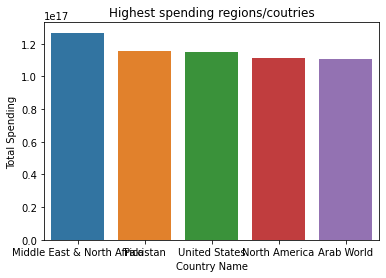

In [ ]:
df_mil_country = df_mil.groupby('Country Name').aggregate(sum)
# df_mil_country['Total'] = df_mil.sum(axis=1,skipna=True)
df_mil_country_top = df_mil_country.sort_values(by=['Total'], ascending=False).head()
df_mil_country_top

## need to fix the overlapping MEA and Pakistan bars
sns.barplot(x=df_mil_country_top.index, y='Total', data=df_mil_country_top)
plt.ylabel("Total Spending")
plt.title("Highest spending regions/coutries") 

Plotting to view the world expenditure above:

In [ ]:
# sns.lineplot(data=df_mil['Total'], x="year", y="")

### Refugee data:

we could get this geo-spatial data: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/25952

I also found the below data set here: https://www.unhcr.org/refugee-statistics/download/?url=S7K0lo

In [ ]:
df_ref = pd.read_csv("population.csv", sep=";")
df_ref

,Year,Country of origin,Country of origin (ISO),Country of asylum,Country of asylum (ISO),Refugees under UNHCR's mandate,Asylum-seekers,IDPs of concern to UNHCR,Venezuelans displaced abroad,Stateless persons,Others of concern
0,1975,Zimbabwe,ZWE,Botswana,BWA,80,0,0,NaN,0,0
1,1975,Zimbabwe,ZWE,Kenya,KEN,60,0,0,NaN,0,0
2,1975,Zimbabwe,ZWE,Mozambique,MOZ,14500,0,0,NaN,0,0
3,1975,Zimbabwe,ZWE,United Rep. of Tanzania,TZA,80,0,0,NaN,0,0
4,1976,Zimbabwe,ZWE,Botswana,BWA,1100,0,0,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...
108170,2020,Afghanistan,AFG,Ukraine,UKR,822,673,0,NaN,0,0
108171,2020,Afghanistan,AFG,Uruguay,URY,5,7,0,NaN,0,0
108172,2020,Afghanistan,AFG,United States of America,USA,1592,796,0,NaN,0,0
108173,2020,Afghanistan,AFG,Uzbekistan,UZB,13,0,0,NaN,0,0


### Total evolution of refugees per year

<AxesSubplot:xlabel='Year'>

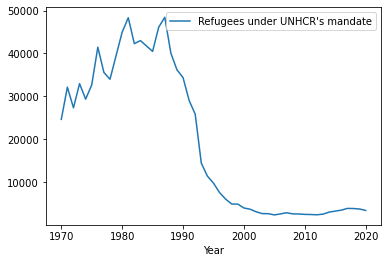

In [ ]:
df_ref_year = df_ref.groupby("Year").aggregate(np.mean).filter(["Refugees under UNHCR's mandate"])
df_ref_year

sns.lineplot(data=df_ref_year)

Interesting to see the UN actually stopped taking refugees after the Mali and Somalia efforts in the 90s. 

## Which country has the most refugees?

In [ ]:
df_ref_country = df_ref.groupby('Country of origin').aggregate(sum)
df_ref_country['Total'] = df_ref.sum(axis=1, skipna=True)
plot_ref_country = df_ref_country['Total'].sort_values(ascending=False).head()
df_ref_country

## To be completed after we discuss where we want to head with
## the addtional data

## lots of cleaning up to do still which I can take care of
## once we all aggree

,Year,Refugees under UNHCR's mandate,Asylum-seekers,IDPs of concern to UNHCR,Venezuelans displaced abroad,Stateless persons,Others of concern,Total
Country of origin,,,,,,,,
Afghanistan,4091202,139624848,2305048,20650774,0.0,0,5697174,689476184.0
Albania,1430628,332009,204073,0,0.0,0,2445,7876620.0
Algeria,2259509,190183,77950,0,0.0,0,272,10111656.0
Andorra,56266,102,52,0,0.0,0,0,225680.0
Angola,2615322,15225833,116668,1040036,0.0,0,399992,77591404.0
...,...,...,...,...,...,...,...,...
Viet Nam,2400301,16160926,65636,0,0.0,0,10168,74548124.0
Western Sahara,445942,6040691,10964,0,0.0,0,208426,26824092.0
Yemen,1965410,564282,155600,18364917,0.0,0,123,84201328.0
